# COGS 108 - EDA Checkpoint

# Names
- Alan Miyazaki
- Alex Guan
- Nathan Ahmann
- Renaldy Herlim

<a id='research_question'></a>
# Research Question

Does crime happen more or less frequently around police stations and can that knowledge be used to more effectively distribute police station locations?

# Setup

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np

# Data Cleaning

Since the two crime datasets were from the same organization (LAPD), the two sets were really easy to combine. The only change that needed to be done was that the dataset from 2010-2019 had a space in column name for Area while the dataset for 2020-present did not. Aside from this, all other columns were the same and the datasets were easily combined. 

The crime dataset had quite a few columns that were unnecessary to us. Mainly these were columns containing codes that law enforcement used internally. However, these columns usually had a description column in the dataset so the code column was unnecessary for us. The only exception were Mocodes and Part 1-2 which are internally used codes but did not contain an associated description column. However after looking into what these code meant, it was decided that they did not provide any use to us and were removed. In addition to this, we also removed Date Rptd, date crime was reported, since we only care about when the crime occured and not when it was reported. We also replaced the codes in Vict Descent with their actual descriptions that was provided in the site the dataset came from. 

In [4]:
# Reading datasets from two different time periods

# https://data.lacity.org/Public-Safety/Crime-Data-from-2010-to-2019/63jg-8b9z
past_df = pd.read_csv("Crime_Data_from_2010_to_2019.csv", dtype = {"TIME OCC": str})
# https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8
present_df = pd.read_csv("Crime_Data_from_2020_to_Present.csv", dtype = {"TIME OCC": str})

LAPD_df = pd.read_csv("LAPD_Police_Stations.csv")

# past dataset has column name typo
past_df = past_df.rename(columns={"AREA ": "AREA"})

# Both datasets use the same columns 
df = pd.concat([past_df, present_df])

In [5]:
# Dropping code columns since these are internal use and we don't get much 
# value from them given we have their description in a seperate column
df = df.drop(columns=[
    "Crm Cd", "Crm Cd 1", "Crm Cd 2", "Crm Cd 3", 
    "Crm Cd 4", "Premis Cd", "Weapon Used Cd", 
    "Mocodes", "Part 1-2", "Status", "Date Rptd"
    ])

# Changed code to be readable description
df["Vict Descent"] = df["Vict Descent"].replace({
                            "A": "Other Asian", 
                            "B": "Black", 
                            "C": "Chinese", 
                            "D": "Cambodian", 
                            "F": "Filipino", 
                            "G": "Guamanian", 
                            "H": "Hispanic/Latin/Mexican", 
                            "I": "American Indian/Alaskan Native", 
                            "J": "Japanese", 
                            "K": "Korean", 
                            "L": "Laotian", 
                            "O": "Other", 
                            "P": "Pacific Islander", 
                            "S": "Samoan", 
                            "U": "Hawaiian", 
                            "V": "Vietnamese", 
                            "W": "White", 
                            "X": "Unknown", 
                            "Z": "Asian Indian",
                        })



To combine our geospatial datasets and make them work with our crime dataset, we had to rename some columns and do some merges. First, we changed the X, Y system used on the LAPD dataset to longitude, latitude to match the crime dataset naming convention.

Additionally, we had to make use of geopandas to read in the precinct area data. This dataset just contains shapes and areas for each precinct and is used for plotting and area data.

In [6]:
# Renamed X,Y to Longitude, Latitude
LAPD_df = LAPD_df.rename(columns={
    "X": "Longitude", 
    "Y": "Latitude"
    })


# https://geohub.lacity.org/datasets/031d488e158144d0b3aecaa9c888b7b3_0/explore?location=33.985210%2C-118.389876%2C11.32
map_df = gpd.read_file('LAPD_Divisions.shp')

Later on in our EDA and analysis we do some additional merges and cleaning caused by them. Those were for specific calculations or plotting though so we left them out of our cleaning section. By this point our dataset is cleaned to an extent for other people to make use of before adding in our own calculated fields that jumble it up.

# Data Analysis & Results (EDA)

The first thing to always do is take a look at the dataset. The police station and geospatial datasets are very straightforward so we are most interested in the crime dataset.

In [7]:
df.head(5)

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,VIOLATION OF COURT ORDER,48,M,Hispanic/Latin/Mexican,SINGLE FAMILY DWELLING,NaN,Adult Arrest,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/12/2010 12:00:00 AM,0045,14,Pacific,1485,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,White,STREET,NaN,Invest Cont,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,1515,13,Newton,1324,OTHER MISCELLANEOUS CRIME,0,M,Hispanic/Latin/Mexican,ALLEY,NaN,Invest Cont,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,0150,6,Hollywood,646,VIOLATION OF COURT ORDER,47,F,White,STREET,HAND GUN,Invest Cont,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/02/2010 12:00:00 AM,2100,1,Central,176,"RAPE, ATTEMPTED",47,F,Hispanic/Latin/Mexican,ALLEY,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,8TH ST,SAN PEDRO ST,34.0387,-118.2488


Just from a quick glance of the first few rows we can see the type of data we have access to.   

We can also see that there are some NaN values, at least in Weapon Desc (which makes sense if the crime did not involve a weapon) and in Cross Street.  

Lastly, we have some columns that won't be useful for us.

Since most of our columns are non-numeric, looking at df.describe() won't be super helpful and instead we need to find our own metrics to look at.

## edit later

look at victim info:  
    m/f distribution  
    at age distribution  
    descent  
    
look at time data  


look at location data!!!  
    lat/lon averages   
    distribution of precinct geographically   
    crimes per precinct   
    area of precinct  


look at unique values for various columns

In [24]:
print('Number of unique crime descriptions: ', df['Crm Cd Desc'].nunique())
print('Number of unique victim descents: ', df['Vict Descent'].nunique())
print('Number of unique status descriptions: ', df['Status Desc'].nunique())
print('Number of unique premise descriptions: ', df['Premis Desc'].nunique())
print('Number of unique area names (should be 21 which corresponds with Precincts): ', df['AREA NAME'].nunique())

Number of unique crime descriptions:  144
Number of unique victim descents:  20
Number of unique status descriptions:  6
Number of unique premise descriptions:  320
Number of unique area names (should be 21 which corresponds with Precincts):  21


In [39]:
pd.DataFrame(columns=['Column','Min', 'Mean', 'Median', 'Max'], data=[
    ['LAT', df['LAT'].min(), df['LAT'].mean(), df['LAT'].median(), df['LAT'].max()],
    ['LON', df['LON'].min(), df['LON'].mean(), df['LON'].median(), df['LON'].max()]
])

,Column,Min,Mean,Median,Max
0,LAT,0.0000,34.038425,34.0617,34.7907
1,LON,-118.8279,-118.223404,-118.3277,0.0000


## Crime Counts in Relation to Precinct

Since our research question involves location information we want to focus our explorations around that. Specifically we would like to see if there are similar amounts of crimes commited in each precinct, if each precinct has similar areas, if each precinct has similar coverage.  

First let's look at the number of crimes in each precinct.

One thing that we would be interested in knowing is if there is an equal distribution of crimes between police stations. From this we can see that there is a difference between how many cases each station has handled. This could either mean that some police stations are responsible for a larger area or there are more crimes happening in the areas those stations are covering. 

<AxesSubplot: ylabel='APREC'>

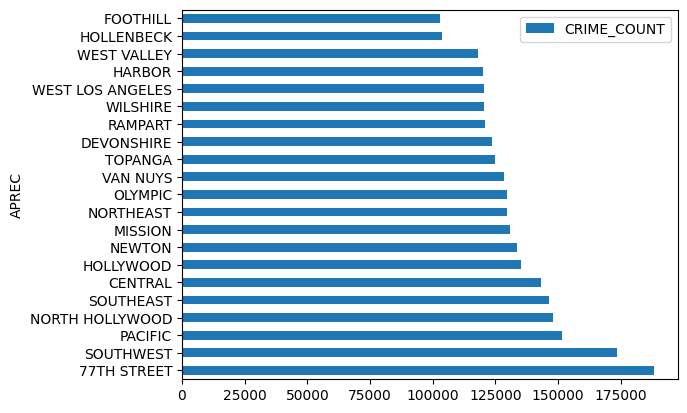

In [14]:
# setting up a merged crime count table that has counts and area of precincts using df and map_df
crime_counts = map_df.merge(df.groupby('AREA')[['DR_NO']].count().rename(columns={'DR_NO':'CRIME_COUNT'}), left_on='PREC', right_on='AREA')
crime_counts = crime_counts.sort_values(by='CRIME_COUNT', ascending=False)
crime_counts.plot(kind='barh', x='APREC', y='CRIME_COUNT')

While there are a few with less and a few with more it seems that there are similar amounts of crime commited in each precint.

But based on our map we know that the precint's are not all the same size, so can the differences in numbers of crime commited be related to size?

array([[<AxesSubplot: title={'center': 'Number of Crimes Committed'}, ylabel='APREC'>,
        <AxesSubplot: title={'center': 'Area of Precinct'}, ylabel='APREC'>,
        <AxesSubplot: title={'center': 'Number of Crimes Committed/ Area'}, ylabel='APREC'>]],
      dtype=object)

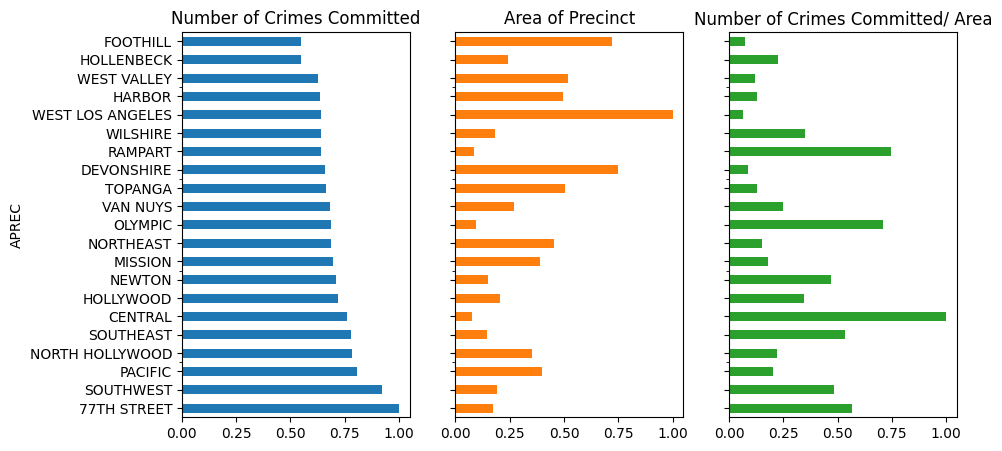

In [16]:
crime_counts['CRIME_COUNT_VS_AREA'] = crime_counts['CRIME_COUNT'] / crime_counts['AREA']

crime_counts['scaled_AREA'] = crime_counts['AREA'] / crime_counts['AREA'].max()
crime_counts['scaled_CRIME_COUNT'] = crime_counts['CRIME_COUNT'] / crime_counts['CRIME_COUNT'].max()
crime_counts['scaled_CRIME_COUNT_VS_AREA'] = crime_counts['CRIME_COUNT_VS_AREA'] / crime_counts['CRIME_COUNT_VS_AREA'].max()
crime_counts.plot(
    kind='barh', 
    x='APREC', 
    y=['scaled_CRIME_COUNT','scaled_AREA','scaled_CRIME_COUNT_VS_AREA'], 
    subplots=True, layout=(1,3), 
    figsize=(10, 5), 
    sharex=True, sharey=True,
    legend=False,
    title=['Number of Crimes Committed', 'Area of Precinct', 'Number of Crimes Committed/ Area']
)

All of the values have been scaled  
The first bar chart is just the number of crimes commited in each area.  
The second is the area of each precint.  
The last bar chart is the number of crimes / the area of the precinct.  
Since the axis are aligned each corresponds to the same area. So despite having an average number of crimes commited, the Central precinct has a very small area compared to the others and gets a higher value on the right bar chart. Since the bars on the right are not all the same size, then that means there is a disparity between the size of a precint and the number of crimes commited there.

array(['VIOLATION OF COURT ORDER',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'OTHER MISCELLANEOUS CRIME', 'RAPE, ATTEMPTED',
       'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
       'BURGLARY FROM VEHICLE',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'BATTERY - SIMPLE ASSAULT', 'ROBBERY', 'BOMB SCARE',
       'CHILD NEGLECT (SEE 300 W.I.C.)',
       'INTIMATE PARTNER - AGGRAVATED ASSAULT',
       'INTIMATE PARTNER - SIMPLE ASSAULT',
       'THEFT PLAIN - PETTY ($950 & UNDER)',
       'CRIMINAL THREATS - NO WEAPON DISPLAYED', 'ATTEMPTED ROBBERY',
       'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 'BURGLARY', 'ARSON',
       'RAPE, FORCIBLE', 'BRANDISH WEAPON',
       'THROWING OBJECT AT MOVING VEHICLE',
       'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
       'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
       'SHOTS FIRED AT INHABITED DWELLING', 'VEHICLE - STOLEN',
    

In [25]:

df["TIME OCC"].value_counts()

1200    140645
1800     80561
2000     75298
1700     72411
1900     71000
         ...  
0543        32
0534        30
0431        25
0531        22
0551        19
Name: TIME OCC, Length: 1439, dtype: int64

This is to see when do most crimes happen. From this we can see that the most common hour for a crime to occur over the past 13 years was at noon. The least common time for a crime to occur was at 5 am. However this is a massive spike at 12 which is odd. A reason for this could be that the dataset only counts crimes reported which means that since it is noon, more people are out and can see/report on a crime. In contrast, people are sleeping at night so there are less people reporting crimes. Another reason for this could be that when a crime happens, they are more focused on the criminal instead of what time it is so when they make a report to an officer, they may choose noon due to it being daylight.

<Axes: >

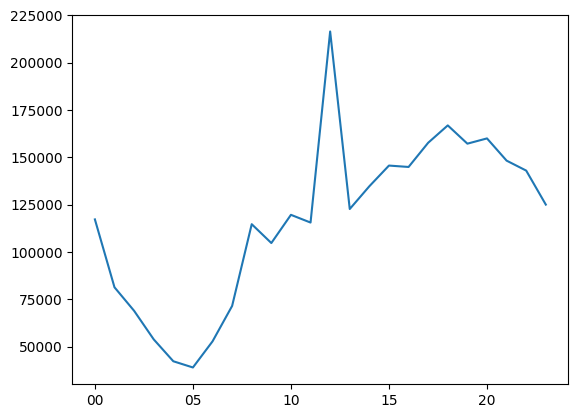

In [26]:
df["TIME OCC"].str[:2].value_counts().sort_index().plot()

In [27]:
df["TIME OCC"].str[:2].value_counts()

12    216387
18    166780
20    159912
17    157612
19    157135
21    148173
15    145565
16    144829
22    142909
14    134643
23    124953
13    122620
10    119551
00    117138
11    115466
08    114609
09    104651
01     81268
07     71435
02     68859
03     53780
06     52716
04     42213
05     38928
Name: TIME OCC, dtype: int64

In [28]:
df["TIME OCC"].value_counts()

1200    140645
1800     80561
2000     75298
1700     72411
1900     71000
         ...  
0543        32
0534        30
0431        25
0531        22
0551        19
Name: TIME OCC, Length: 1439, dtype: int64

In [29]:
df["DATE OCC"].value_counts().sort_index()

01/01/2010 12:00:00 AM    2311
01/01/2011 12:00:00 AM    2248
01/01/2012 12:00:00 AM    1859
01/01/2013 12:00:00 AM    1695
01/01/2014 12:00:00 AM    1597
                          ... 
12/31/2018 12:00:00 AM     607
12/31/2019 12:00:00 AM     554
12/31/2020 12:00:00 AM     573
12/31/2021 12:00:00 AM     571
12/31/2022 12:00:00 AM     556
Name: DATE OCC, Length: 4820, dtype: int64

<Axes: >

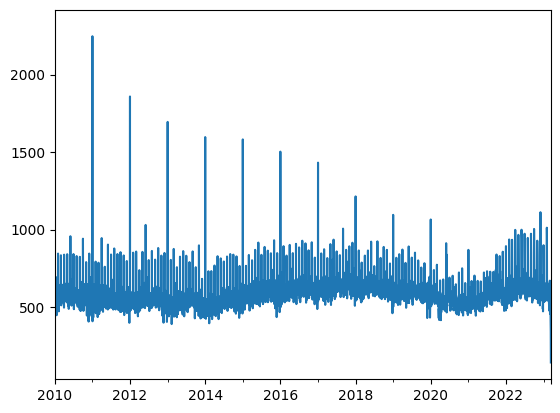

In [30]:
pd.to_datetime(df["DATE OCC"]).value_counts().sort_index().plot()

Seems like there are more crimes happening during new years?

In [31]:
df.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,VIOLATION OF COURT ORDER,48,M,Hispanic/Latin/Mexican,SINGLE FAMILY DWELLING,NaN,Adult Arrest,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/12/2010 12:00:00 AM,0045,14,Pacific,1485,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,White,STREET,NaN,Invest Cont,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,1515,13,Newton,1324,OTHER MISCELLANEOUS CRIME,0,M,Hispanic/Latin/Mexican,ALLEY,NaN,Invest Cont,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,0150,6,Hollywood,646,VIOLATION OF COURT ORDER,47,F,White,STREET,HAND GUN,Invest Cont,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/02/2010 12:00:00 AM,2100,1,Central,176,"RAPE, ATTEMPTED",47,F,Hispanic/Latin/Mexican,ALLEY,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,8TH ST,SAN PEDRO ST,34.0387,-118.2488


In [32]:
pd.to_datetime(df["DATE OCC"]).value_counts()

2010-01-01    2311
2011-01-01    2248
2012-01-01    1859
2013-01-01    1695
2014-01-01    1597
              ... 
2011-12-26     398
2014-02-09     395
2013-02-09     390
2023-03-12     343
2023-03-13     142
Name: DATE OCC, Length: 4820, dtype: int64

Number of crimes reported plotted by month and year

<Axes: >

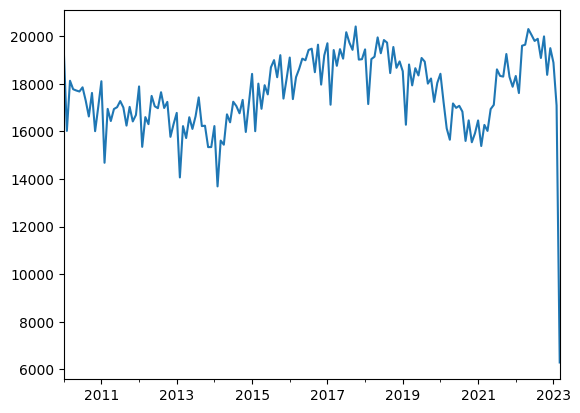

In [33]:
pd.to_datetime(df["DATE OCC"]).dt.to_period('M').value_counts().sort_index().plot()

In [34]:
pd.to_datetime(df["DATE OCC"]).dt.to_period('M').value_counts()

2017-10    20410
2022-05    20302
2017-07    20169
2022-06    20058
2022-10    19993
           ...  
2013-11    15340
2011-02    14681
2013-02    14065
2014-02    13688
2023-03     6287
Freq: M, Name: DATE OCC, Length: 159, dtype: int64

This is number of crims reported over years. 2023 is extremely low because the year is going on.

<Axes: >

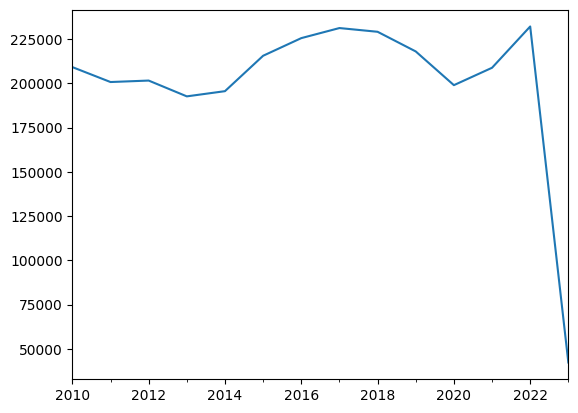

In [35]:
pd.to_datetime(df["DATE OCC"]).dt.to_period('Y').value_counts().sort_index().plot()

In [36]:
pd.to_datetime(df["DATE OCC"]).dt.to_period('Y').value_counts()

2022    232194
2017    231303
2018    229197
2016    225609
2019    218088
2015    215641
2010    209229
2021    208854
2012    201621
2011    200792
2020    199022
2014    195628
2013    192689
2023     42265
Freq: A-DEC, Name: DATE OCC, dtype: int64

Removing 2023 to get a better graph. We can see some oddities. 2013, 2014, and 2020 are low in comparison to other years. 2020 is likely due to the pandemic since everyone was encouraged to stay at home which leads to less crimes reported (and maybe less crimes happening?). I have no idea of any reason to explain why 2013 and 2014 are so low. In addition its a bit weird that crime starts picking to make a curve at 2017. Also a massive spite at 2022 as well but not too sure of the reason there. 

<Axes: >

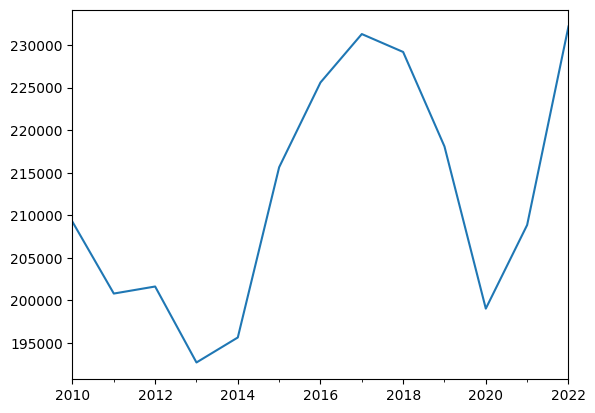

In [37]:
pd.to_datetime(df["DATE OCC"]).dt.to_period('Y').value_counts().sort_index()[:-1].plot()

In [70]:
LAPD_df.head()

,Longitude,Latitude,OBJECTID,DIVISION,LOCATION,PREC
0,-118.289242,33.757661,1,HARBOR,2175 JOHN S. GIBSON BLVD.,5
1,-118.275394,33.938627,2,SOUTHEAST,145 W. 108TH ST.,18
2,-118.277670,33.970307,3,77TH STREET,7600 S. BROADWAY,12
3,-118.419842,33.991655,4,PACIFIC,12312 CULVER BLVD.,14
4,-118.305142,34.010575,5,SOUTHWEST,1546 MARTIN LUTHER KING JR. BLVD.,3


## Looking at New Years data from 2010 to 2023

In [71]:
# Make a copy of the dataframe and create a new one with a datetime column for easy filtering
datetime_col = pd.to_datetime(df['DATE OCC'])
new_df = df.copy()
new_df['Date'] = datetime_col
new_df.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,Cross Street,LAT,LON,Date
0,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,VIOLATION OF COURT ORDER,48,M,Hispanic/Latin/Mexican,SINGLE FAMILY DWELLING,NaN,Adult Arrest,300 E GAGE AV,NaN,33.9825,-118.2695,2010-02-20
1,11401303,09/12/2010 12:00:00 AM,0045,14,Pacific,1485,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,White,STREET,NaN,Invest Cont,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,2010-09-12
2,70309629,08/09/2010 12:00:00 AM,1515,13,Newton,1324,OTHER MISCELLANEOUS CRIME,0,M,Hispanic/Latin/Mexican,ALLEY,NaN,Invest Cont,1300 E 21ST ST,NaN,34.0224,-118.2524,2010-08-09
3,90631215,01/05/2010 12:00:00 AM,0150,6,Hollywood,646,VIOLATION OF COURT ORDER,47,F,White,STREET,HAND GUN,Invest Cont,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,2010-01-05
4,100100501,01/02/2010 12:00:00 AM,2100,1,Central,176,"RAPE, ATTEMPTED",47,F,Hispanic/Latin/Mexican,ALLEY,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,8TH ST,SAN PEDRO ST,34.0387,-118.2488,2010-01-02


In [72]:
# Create new dataframe that only contains crimes on New Years Day from 2010 - 2023
new_years = new_df[(new_df['Date'].dt.month == 1) & (new_df['Date'].dt.day == 1)]
new_years.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,Cross Street,LAT,LON,Date
448,100104004,01/01/2010 12:00:00 AM,0130,1,Central,162,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",35,M,Other,POLICE FACILITY,BLUNT INSTRUMENT,Adult Arrest,7TH ST,FLOWER ST,34.0487,-118.2588,2010-01-01
449,100104006,01/01/2010 12:00:00 AM,0230,1,Central,171,BATTERY - SIMPLE ASSAULT,30,M,Hispanic/Latin/Mexican,STREET,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,OLYMPIC BL,FIGUEROA BL,34.0453,-118.2651,2010-01-01
450,100104007,01/01/2010 12:00:00 AM,0100,1,Central,111,BURGLARY FROM VEHICLE,32,M,Hispanic/Latin/Mexican,PARKING UNDERGROUND/BUILDING,NaN,Invest Cont,600 N HILL ST,NaN,34.0591,-118.2412,2010-01-01
451,100104012,01/01/2010 12:00:00 AM,1145,1,Central,152,BATTERY - SIMPLE ASSAULT,51,M,Hispanic/Latin/Mexican,OTHER/OUTSIDE,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,FLOWER,WILSHIRE,34.0494,-118.2581,2010-01-01
452,100104021,01/01/2010 12:00:00 AM,1130,1,Central,100,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",51,M,Black,SIDEWALK,UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,6TH ST,WALL ST,34.0428,-118.2461,2010-01-01


In [73]:
# Over 20,000 crimes committed on the 13 New Years day's alone!
new_years.shape

(20262, 18)

#### 13 days are accounting for over 20,000 crimes in total, with an average of 1558 per day

In [64]:
20262/13

1558.6153846153845

In [59]:
365 * 12 + (80)

4460

In [61]:
(df.shape[0] / 4460) * 13

8167.64932735426

In [63]:
new_years['Vict Descent'].value_counts()

Hispanic/Latin/Mexican            9225
White                             4166
Black                             3034
Other                             1796
Unknown                            508
Other Asian                        426
Korean                              85
Filipino                            52
Chinese                             20
Japanese                            12
American Indian/Alaskan Native      10
Vietnamese                           6
Hawaiian                             5
Pacific Islander                     4
Asian Indian                         4
Guamanian                            1
Cambodian                            1
Name: Vict Descent, dtype: int64

In [74]:
top_20 = new_years['Crm Cd Desc'].value_counts()[:20]
top_20

THEFT OF IDENTITY                                           6542
CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)    1376
BATTERY - SIMPLE ASSAULT                                    1044
INTIMATE PARTNER - SIMPLE ASSAULT                            811
BURGLARY FROM VEHICLE                                        643
VEHICLE - STOLEN                                             623
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD     599
BURGLARY                                                     595
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT               584
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)      560
THEFT PLAIN - PETTY ($950 & UNDER)                           524
RAPE, FORCIBLE                                               513
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)              485
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                     430
SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ     386
LETTERS, LEWD  -  TELEPHO

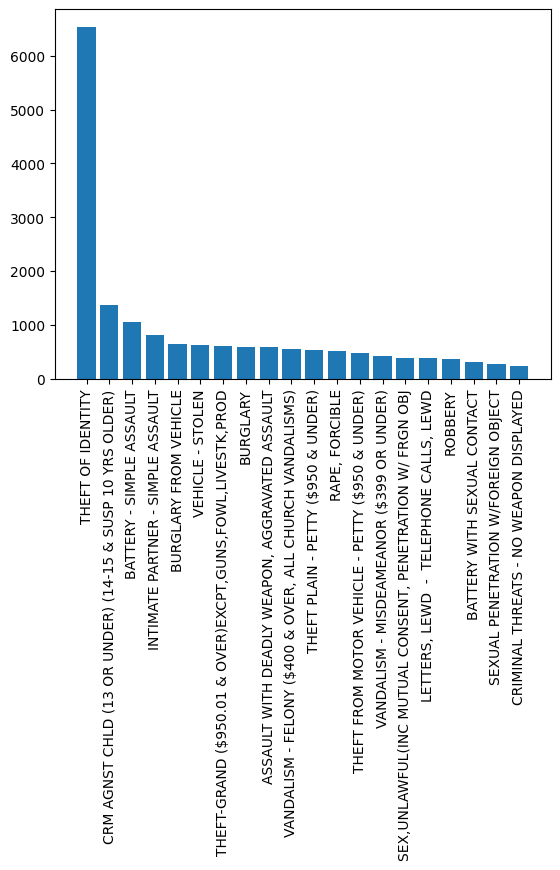

In [77]:
plt.bar(top_20.index, top_20)
plt.xticks(rotation = 90)
plt.show()

,Longitude,Latitude,OBJECTID,DIVISION,LOCATION,PREC,DR_NO


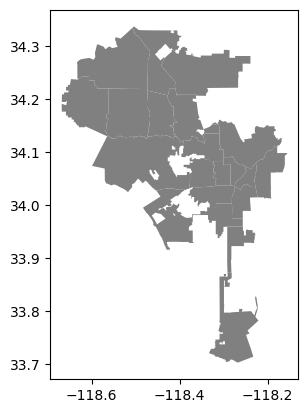

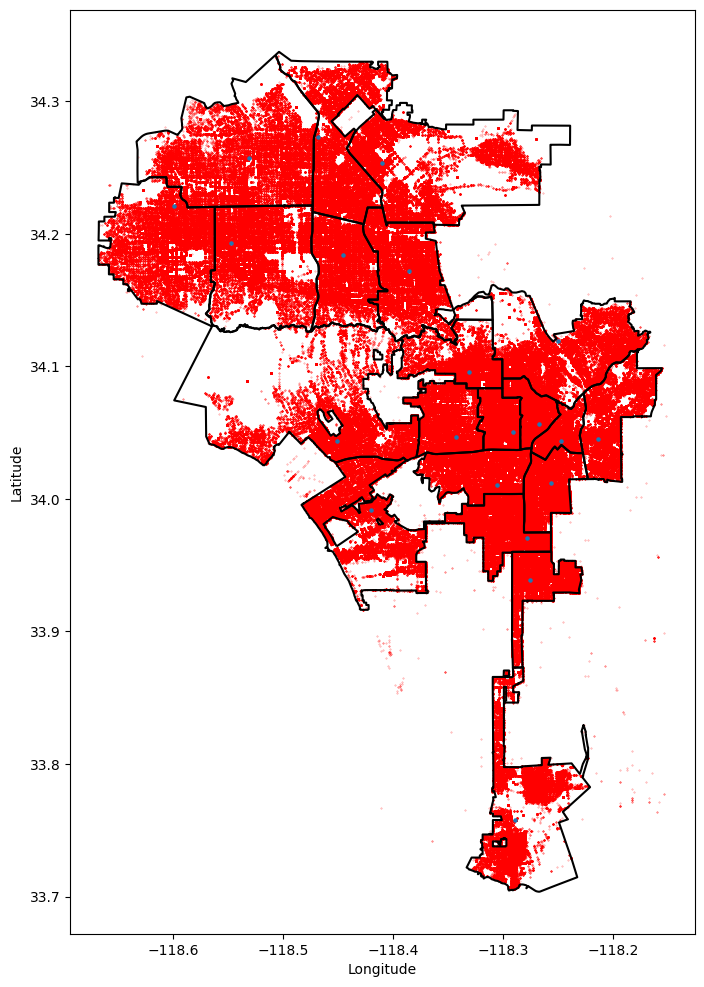

In [81]:
import geopandas as gpd
import matplotlib.pyplot as plt

# https://geohub.lacity.org/datasets/031d488e158144d0b3aecaa9c888b7b3_0/explore?location=33.985210%2C-118.389876%2C11.32

map_df = gpd.read_file('LAPD_Divisions.shp')
map_df.plot(color='gray')

df_plot = df.loc[(df['LAT'] >= 33.7) & (df['LAT'] <= 34.37) & (df['LON'] >= -118.7) & (df['LON'] <= -118.15)]

fig, ax = plt.subplots(1, figsize = (20, 12))
map_df.boundary.plot(color='black', ax=ax)
df_plot.plot(ax=ax, x='LON', y='LAT', kind='scatter', color='red',  s=0.1, alpha=0.5)
LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=5)

LAPD_df.merge(df.groupby('AREA')[['DR_NO']].count(), left_on='PREC', right_on='DR_NO')